In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import numpy as np
import os

import chainer
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

root = '/home/wei/Data/Loop_detection'

In [75]:
from chainercv.visualizations import vis_bbox

In [69]:
from utils import DefectDetectionDataset

In [85]:
dataset = DefectDetectionDataset.DefectDetectionDataset()

(7, 4)
(7,)


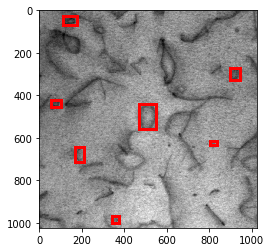

In [95]:
img, bbox, label = dataset[0]
print(bbox.shape)  # (2, 4)
print(label.shape)  # (2,)
vis_bbox(img, bbox, label)
plt.show()

In [19]:
data_dir = root
images_file = os.path.join(data_dir, 'images.txt')
f = open(images_file)

In [20]:
images = [line.strip() for line in f]

In [21]:
images

['0501_300kx_1nm_clhaadf3_0006.jpg',
 '0501_300kx_1nm_clhaadf3_0008.jpg',
 '0501_300kx_1nm_clhaadf3_0010.jpg',
 '0501_300kx_1nm_clhaadf3_0012.jpg',
 '0501_300kx_1nm_clhaadf3_0014.jpg',
 '0501_300kx_1nm_clhaadf3_0016.jpg',
 '0501_300kx_1nm_clhaadf3_0018.jpg',
 '0501_300kx_1nm_clhaadf3_0020.jpg',
 '0501_300kx_1nm_clhaadf3_0022.jpg',
 '0501_300kx_1nm_clhaadf3_0024.jpg',
 '0501_300kx_1nm_clhaadf3_0026.jpg',
 '0501_300kx_1nm_clhaadf3_0028.jpg',
 '0501_300kx_1nm_clhaadf3_0030.jpg',
 '0501_300kx_1nm_clhaadf3_0031.jpg',
 '0501_300kx_1nm_clhaadf3_0034.jpg',
 '0501_300kx_1nm_clhaadf3_0036.jpg',
 '0501_300kx_1nm_clhaadf3_0038.jpg',
 '0501_300kx_1nm_clhaadf3_0040.jpg',
 '0501_300kx_1nm_clhaadf3_0044.jpg',
 '0501_300kx_1nm_clhaadf3_0046.jpg',
 '0501_300kx_1nm_clhaadf3_0048.jpg',
 '0501_300kx_1nm_clhaadf3_0050.jpg',
 '1ROI_100kx_4100CL_foil1.jpg',
 '200kV_500kx_p2nm_8cmCL_grain1_0002.jpg',
 '200kV_500kx_p2nm_8cmCL_grain1_0002_n.jpg',
 '200kV_500kx_p2nm_8cmCL_grain1_0004_n.jpg',
 '200kV_500kx_p2nm_8c

In [38]:
bbs_file = os.path.join(root, "bounding_boxes", str('0501_300kx_1nm_clhaadf3_0031.jpg'[0:-4] +'.txt'))

In [47]:
bbs = np.stack([line.strip().split() for line in open(bbs_file)]).astype(np.float32)

In [48]:
bbs.shape

(7, 4)

In [52]:
np.stack([1]*bbs.shape[0]).astype(np.int32)

array([1, 1, 1, 1, 1, 1, 1], dtype=int32)